In [148]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.sandbox.stats.multicomp import multipletests
from collections import Counter
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes

%matplotlib inline

## 1.

In [149]:
data = pd.read_excel("Данные/intersalt.xlsx")
data.head()

,b,bp,na,country
1,0.512,72.0,149.3,Argentina
2,0.226,78.2,133.0,Belgium
3,0.316,73.9,142.6,Belgium
4,0.042,61.7,5.8,Brazil
5,0.086,61.4,0.2,Brazil


MSE: 19.53833326119419
Коэффициенты регрессии (наклон и сдвиг):
0.0377216368041
67.5579864172


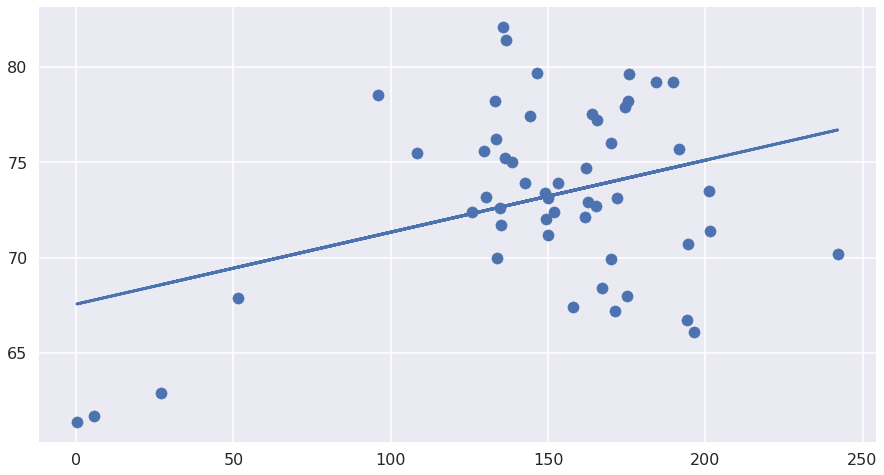

In [150]:
X = data[["na"]]
y = data["bp"]

lr = LinearRegression()
lr.fit(X, y)
print("MSE: {}".format(mean_squared_error(lr.predict(X), y)))
print("Коэффициенты регрессии (наклон и сдвиг):")
print(lr.coef_[0])
print(lr.intercept_)
plt.figure(figsize=(15, 8))
plt.scatter(X.values[:, 0], y)
plt.plot(X.values[:, 0], lr.predict(X))

In [151]:
mu = data.na.values.mean()
sigma = data.na.values.std()
mu, sigma

(148.34615384615384, 45.201108144765577)

Удалим как выбросы те значения, которые отклоняются от среднего больше, чем на 2 стандартных отклонения. 

In [161]:
low = mu - 2 * sigma
high = mu + 2 * sigma
low, high

(57.943937556622686, 238.74837013568498)

MSE: 14.159017389208543
Коэффициенты регрессии (наклон и сдвиг):
-0.044432369227
81.0246267527


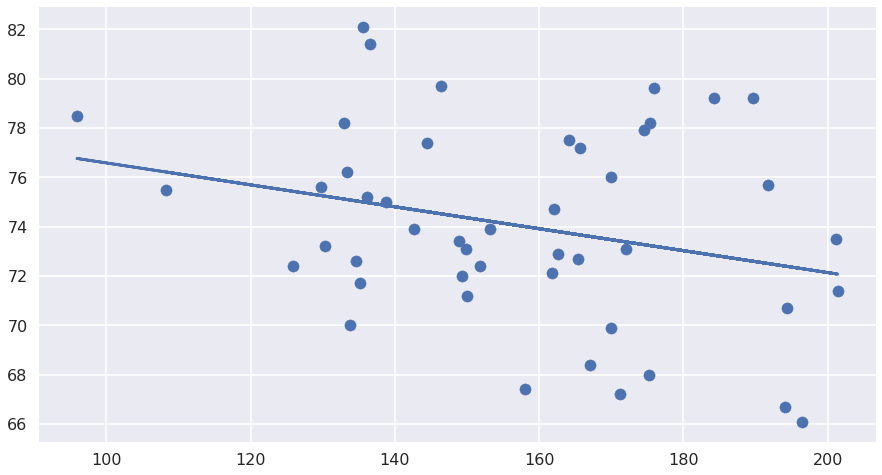

In [162]:
X = data[["na"]][np.logical_and(low < data.na, data.na < high)]
y = data["bp"].values[np.logical_and(low < data.na, data.na < high)]

lr = LinearRegression()
lr.fit(X, y)
print("MSE: {}".format(mean_squared_error(lr.predict(X), y)))
print("Коэффициенты регрессии (наклон и сдвиг):")
print(lr.coef_[0])
print(lr.intercept_)
plt.figure(figsize=(15, 8))
plt.scatter(X.values[:, 0], y)
plt.plot(X.values[:, 0], lr.predict(X))

Можно видеть, что после удаления выбросов MSE существенно уменьшилась.

## 2.

Загрузка датасета.

In [12]:
data_dict = load_diabetes()
print(data_dict['DESCR'])

Diabetes dataset

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani

In [14]:
target = data_dict['target']
columns = ["Age", "Sex", "Body mass index", "Average blood pressure", 
           "S1", "S2", "S3", "S4", "S5", "S6"]
data = pd.DataFrame(data_dict['data'], columns=columns)
data.head()

,Age,Sex,Body mass index,Average blood pressure,S1,S2,S3,S4,S5,S6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


Разобиение данных на обучающую и тестовую части в соотношении 80:20.

In [15]:
X_tr, X_te, y_tr, y_te = train_test_split(data, target, test_size=0.2, random_state=42)

(а) Построение линейной регрессии по всем регрессорам и подсчет MSE по тестовой части

In [17]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)
mse = mean_squared_error(lr.predict(X_te), y_te)
print("MSE на тестовой части: {}".format(mse))

MSE на тестовой части: 2900.1732878832318


(b) Построение линейной регрессии по регрессорам "пол" и "возраст" и графика зависимости развития диабета от возраста для каждого пола

In [28]:
lr = LinearRegression()
features = ["Age", "Sex"]
lr.fit(X_tr[features], y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

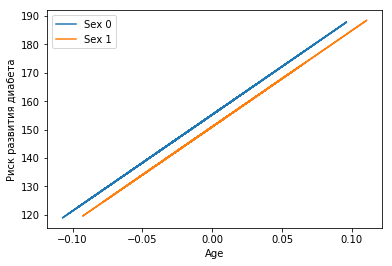

In [36]:
for i, sex in enumerate(np.unique(X_te["Sex"])):
    plt.plot(X_te[X_te["Sex"] == sex]["Age"], lr.predict(X_te[X_te["Sex"] == sex][features]), label="Sex {}".format(i))
plt.xlabel("Age")
plt.ylabel("Риск развития диабета")
plt.legend()
plt.show()

Как можно видеть, для одного из полов (Sex 0) риск развития диабета в том же возрасте выше.

(c) Зависимость риска развития диабета от индекса массы тела.

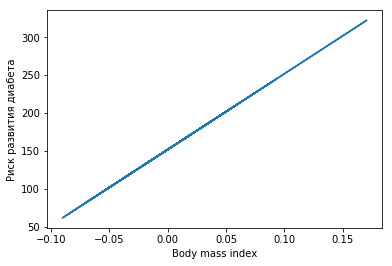

In [42]:
lr = LinearRegression()
features = ["Body mass index"]
lr.fit(X_tr[features], y_tr)

plt.plot(X_te[features], lr.predict(X_te[features]))
plt.xlabel("Body mass index")
plt.ylabel("Риск развития диабета")
plt.show()

Как можно видеть, риск развития диабета возрастает с увеличением индекса массы тела.

(d) Подсчет MSE на тесте и сравнение предсказаний для всех комбинаций регрессоров.

In [93]:
n_features = len(columns)
subsets = []
for k in range(1, n_features):
    subsets += list(combinations(np.arange(k + 1), k))
subsets = list(map(list, subsets))

mse_l = []
for subset in subsets:
    lr.fit(X_tr.iloc[:, subset], y_tr)
    mse_l.append(mean_squared_error(lr.predict(X_te.iloc[:, subset]), y_te))

In [105]:
regressors = ", ".join(X_te.columns[subsets[np.argmin(mse_l)]].tolist())

print("Минимальная MSE: {}".format(np.min(mse_l)))
print("Комбинация регрессоров: {}".format(regressors))

Минимальная MSE: 2855.3010713053127
Комбинация регрессоров: Age, Sex, Body mass index, Average blood pressure, S1, S2, S3, S5, S6


Комбинация регрессоров Age, Sex, Body mass index, Average blood pressure, S1, S2, S3, S5, S6 наилучшим образом предсказывает риск развития диабета.

## 3.

In [73]:
data = pd.read_excel("Данные/Weight.xlsx")
data.head()

,do,posle
0,125.7,128.0
1,94.7,95.1
2,99.6,93.3
3,102.7,104.1
4,108.6,109.8


Проверка на нормальность данных "до" и "после" (для удобства приведенных к нулевому среднему и единичной дисперсии).

In [74]:
sns.set(style='darkgrid', context='poster')

def apply_kstest(sample, cdf=sps.norm.cdf):
    print(sps.kstest(sample, sps.norm.cdf))

    ecdf = ECDF(sample)
    grid = np.linspace(-3, 3, 500)

    plt.figure(figsize=(8, 3.5))
    plt.plot(grid, ecdf(grid), color='red', label='ecdf', lw=2)
    plt.plot(grid, cdf(grid), color='blue', label='cdf', lw=2)
    plt.legend()
    plt.show()

In [75]:
do_norm = (data["do"] - data["do"].mean()) / data["do"].std()
posle_norm = (data[" posle"] - data[" posle"].mean()) / data[" posle"].std()

KstestResult(statistic=0.13868986986632259, pvalue=0.64789780965834098)


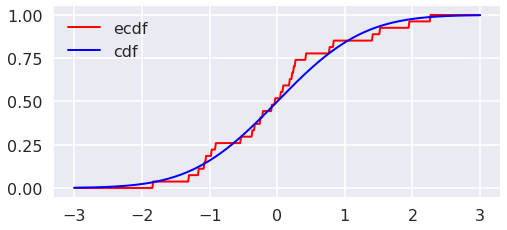

In [77]:
apply_kstest(do_norm)

KstestResult(statistic=0.12510897002151111, pvalue=0.79337092472075543)


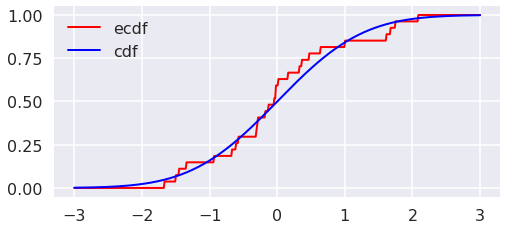

In [78]:
apply_kstest(posle_norm)

По значениям p-value нельзя отклонить гипотезу о нормальном распределении данных.

Проверка гипотезы H0 (лечение не меняет вес) против альтернативы H1 (вес до больше, чем вес после).
Так как данные приведены для одних и тех же пациенток, испольуется t-test для связанных выборок.

In [81]:
sample_1 = data["do"]
sample_2 = data[" posle"]
sps.ttest_rel(sample_1, sample_2)

Ttest_relResult(statistic=2.6094954178475724, pvalue=0.014841265343339209)

t-statistic > 0 и p-value < 0.05 / 2 = 0.025 => гипотеза H0 должна быть отклонена в пользу альтернативы H1 на уровне значимости 5% (действие лечения значимо).

## 4.

In [82]:
data = pd.read_excel("Данные/Pressure.xlsx", header=None, names=["do", " posle"])
data.head()

,do,posle
0,146,150
1,146,143
2,156,157
3,132,132
4,124,119


Проверка на нормальность данных "до" и "после" (для удобства приведенных к нулевому среднему и единичной дисперсии).

In [83]:
do_norm = (data["do"] - data["do"].mean()) / data["do"].std()
posle_norm = (data[" posle"] - data[" posle"].mean()) / data[" posle"].std()

KstestResult(statistic=0.059614744695681621, pvalue=0.82919811143267774)


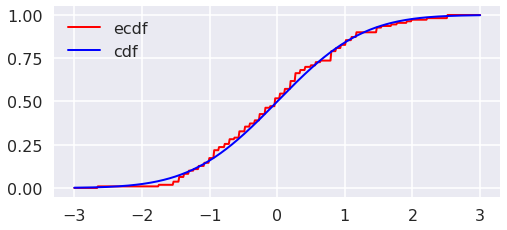

In [84]:
apply_kstest(do_norm)

KstestResult(statistic=0.059763477666507581, pvalue=0.82692922019900861)


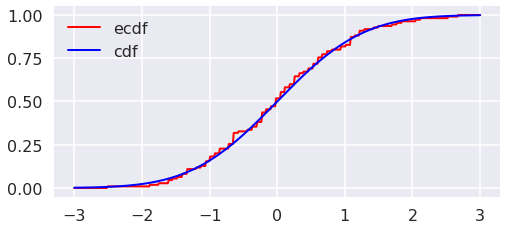

In [85]:
apply_kstest(posle_norm)

По значениям p-value нельзя отклонить гипотезу о нормальном распределении данных.

Проверка гипотезы H0 (лекарство не меняет давление) против альтернативы H1 (давление до больше, чем давление после).
Так как данные приведены для одних и тех же пациентов, испольуется t-test для связанных выборок.

In [86]:
sample_1 = data["do"]
sample_2 = data[" posle"]
sps.ttest_rel(sample_1, sample_2)

Ttest_relResult(statistic=2.3523081589825714, pvalue=0.020452139922113512)

t-statistic > 0 и p-value < 0.05 / 2 = 0.025 => гипотеза H0 должна быть отклонена в пользу альтернативы H1 на уровне значимости 5% (действие лекарства значимо).

## 5.

In [88]:
data = pd.read_excel("Данные/Bloodplasma.xlsx", header=None, names=["volume"])
data.head()

,volume
0,3.073839
1,2.878799
2,3.223569
3,3.120090
4,3.154265


In [89]:
data.columns

Index(['volume'], dtype='object')

Точечные оценки.

In [90]:
# (a) mu
mu = data.volume.mean()
print("точечная оценка mu: {}".format(mu))

точечная оценка mu: 3.252187885207087


In [91]:
# (b) sigma^2, sigma
sigma_2 = data.volume.var()
sigma = data.volume.std()
print("точечная оценка sigma^2: {}".format(sigma_2))
print("точечная оценка sigma: {}".format(sigma))

точечная оценка sigma^2: 0.20884121856716018
точечная оценка sigma: 0.4569914863180278


(c) 95%-ый доверительный интервал для mu.

In [97]:
print("95%-ый доверительный интервал для mu:")
print(sps.t.interval(0.95, data.volume.size - 1, loc=mu, scale=sps.sem(data.volume)))

95%-ый доверительный интервал для mu:
(3.0975642119542308, 3.406811558459943)


(d) Проверка данных на нормальность.

In [98]:
volume_norm = (data["volume"] - mu) / sigma

KstestResult(statistic=0.14039016459758047, pvalue=0.44165590180538383)


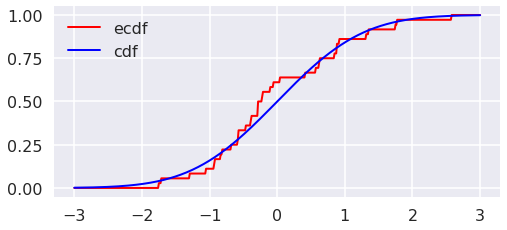

In [99]:
apply_kstest(volume_norm)

По значению p-value нельзя отклонить гипотезу о нормальном распределении данных.